# Spectrogram classification
AIFFEL 대전 탐색 노드 5    
음성데이터를 분류하는 모델 만들기이다.(10여개의 단어들)

프로세스는 다음과 같다.  (세부설명은 노드에 있는 것을 가지고 왔다.)    
0. Import package
1. Data processing   
    라벨 데이터 처리하기   
    sklearn의 train_test_split함수를 이용하여 train, test 분리   
    spectrogram으로 변환   

2. Hyperparameter setting
3. Dataset    
    tf.data.Dataset을 이용   
    from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용   
    map과 batch를 이용한 데이터 전처리
      
4. Modeling for spectrogram   
    batchnorm, dropout, dense layer 등을 이용   
    12개의 단어 class를 구분하는 loss를 사용하고 Adam optimizer를 사용   
    모델 가중치를 저장하는 checkpoint callback 함수 추가   

5. Training & visualization   
    loss, accuracy를 그래프로 표현
    
6. Evaluation
    저장한 weight 불러오기   
    모델의 예측값과 정답값이 얼마나 일치하는지 확인


## 0. Import package

In [1]:
import numpy as np
import os
import IPython.display as ipd
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import librosa
import librosa.display

## 1. Data processing

In [2]:
#data loading
data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)


In [3]:
# data sampling for checking
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  9309
Wave data shape :  (8000,)
label :  ['off']


### Labeling

In [4]:
#labeling
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [5]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

array([ 3,  3,  3, ..., 11, 11, 11])

### Data split

In [6]:
#data split
sr = 8000 # data sampling number
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
del speech_data

In [7]:
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)

train data :  (45558, 8000)
train labels :  (45558,)
test data :  (5062, 8000)
test labels :  (5062,)


### Data transformation (wav to spectrogram)

(45558, 130, 126)
Waveform shape :  (45558, 8000)
Spectrogram shape :  (45558, 130, 126)


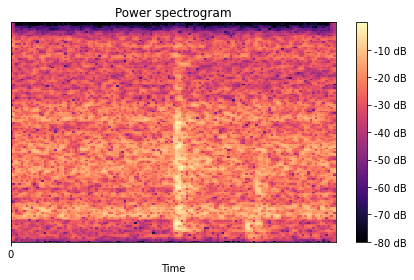

In [8]:
#wav to spectrogram
def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

# for train
train_spec=[] 
for wav in train_wav: 
    stft = wav2spec(wav)
    train_spec.append(stft)
train_spec = np.array(train_spec)
print(train_spec.shape)

print("Waveform shape : ",train_wav.shape)
print("Spectrogram shape : ",train_spec.shape)
del train_wav

# sampling for checking
librosa.display.specshow(librosa.amplitude_to_db(train_spec[0], ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

(5062, 130, 126)
Waveform shape :  (5062, 8000)
Spectrogram shape :  (5062, 130, 126)


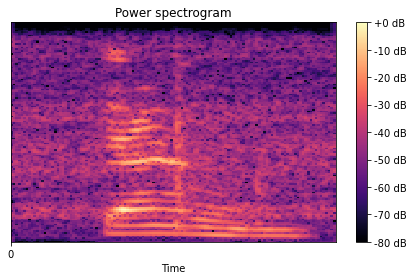

In [9]:
# for test
test_spec=[] 
for wav in test_wav: 
    stft = wav2spec(wav)
    test_spec.append(stft)
test_spec = np.array(test_spec)
print(test_spec.shape)

print("Waveform shape : ",test_wav.shape)
print("Spectrogram shape : ",test_spec.shape)
del test_wav

# sampling for checking
librosa.display.specshow(librosa.amplitude_to_db(test_spec[0], ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

## 2. hyperparameter setting

In [10]:
batch_size = 8
max_epochs = 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/spec'

checkpoint_dir

'/home/aiffel-dj28/aiffel/speech_recognition/models/spec'

## 3. Dataset

In [11]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_spec, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_spec, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)


<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>


## 4. Modeling
빠른 학습을 위해서 모댈을 기존 예제에서 축소시켰다.   
기본적으로 conv1D layer가 중심이 되는 모델과   
처음 모델에서 resnet 아이디어를 추가한 모델
2가지를 만들었다.

In [12]:
input_tensor = layers.Input(shape=(130, 126))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

# 모델이 커서 축소 하였다.
#x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
#x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
#x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
#x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_spec = tf.keras.Model(input_tensor, output_tensor)

model_spec.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 126)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 130, 32)           36320     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 130, 32)           9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 65, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 65, 64)            18496     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 65, 64)            36928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 64)            0     

In [13]:
# optimizer and loss function setting
optimizer=tf.keras.optimizers.Adam(1e-4)
model_spec.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

In [14]:
# save the model (best)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

## 5. Training & visualization

In [15]:
#30분 내외 소요 (메모리 사용량에 주의해 주세요.)
history_wav = model_spec.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/10
5688/5694 [============================>.] - ETA: 0s - loss: 1.4531 - accuracy: 0.5105
Epoch 00001: val_loss improved from inf to 0.75400, saving model to /home/aiffel-dj28/aiffel/speech_recognition/models/spec
5694/5694 [==============================] - 26s 5ms/step - loss: 1.4530 - accuracy: 0.5106 - val_loss: 0.7540 - val_accuracy: 0.7551
Epoch 2/10
5694/5694 [==============================] - ETA: 0s - loss: 0.7311 - accuracy: 0.7622
Epoch 00002: val_loss improved from 0.75400 to 0.46464, saving model to /home/aiffel-dj28/aiffel/speech_recognition/models/spec
5694/5694 [==============================] - 26s 5ms/step - loss: 0.7311 - accuracy: 0.7622 - val_loss: 0.4646 - val_accuracy: 0.8445
Epoch 3/10
5687/5694 [============================>.] - ETA: 0s - loss: 0.5316 - accuracy: 0.8275
Epoch 00003: val_loss improved from 0.46464 to 0.44300, saving model to /home/aiffel-dj28/aiffel/speech_recognition/models/spec
5694/5694 [==============================] - 27s 5ms/step 

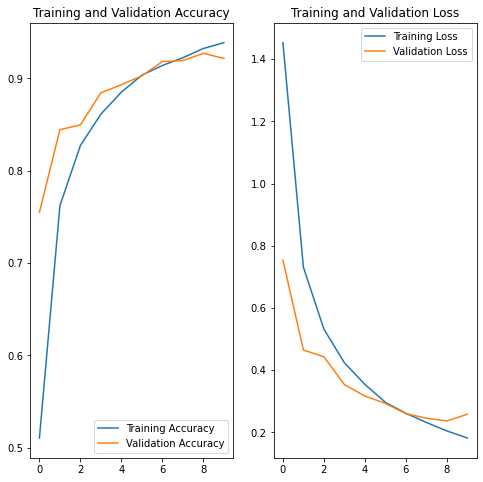

In [16]:
# visualization for training
acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 6. Evaluation

In [17]:
# loading weights
model_spec.load_weights(checkpoint_dir)
results = model_spec.evaluate(test_dataset)
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

633/633 [==============================] - 20s 31ms/step - loss: 0.2367 - accuracy: 0.9271
loss value: 0.237
accuracy value: 92.7104%


## Another Modeling

In [18]:
input_tensor = layers.Input(shape=(130, 126))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
x = layers.MaxPool1D()(x)


#x = layers.Conv1D(256, 9, padding='same', activation='relu')(skip_3)
#x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
#x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
#x = tf.concat([x, skip_3], -1)
#x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_spec_skip = tf.keras.Model(input_tensor, output_tensor)

model_spec_skip.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 130, 126)]   0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 130, 32)      36320       input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 130, 32)      9248        conv1d_7[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_3 (MaxPooling1D)  (None, 65, 32)       0           conv1d_8[0][0]                   
____________________________________________________________________________________________

## Training & visualization

In [19]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_spec_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
checkpoint_dir_2 = os.getenv('HOME')+'/aiffel/speech_recognition/models/spec_skip'
cp_callback_2 = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir_2,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
#30분 내외 소요 (메모리 사용량에 주의해 주세요.)
history_wav_2 = model_spec_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[cp_callback_2]
                    )

Epoch 1/10
5690/5694 [============================>.] - ETA: 0s - loss: 1.4603 - accuracy: 0.5076
Epoch 00001: val_loss improved from inf to 0.76061, saving model to /home/aiffel-dj28/aiffel/speech_recognition/models/spec_skip
5694/5694 [==============================] - 29s 5ms/step - loss: 1.4603 - accuracy: 0.5076 - val_loss: 0.7606 - val_accuracy: 0.7480
Epoch 2/10
5683/5694 [============================>.] - ETA: 0s - loss: 0.7293 - accuracy: 0.7621
Epoch 00002: val_loss improved from 0.76061 to 0.49194, saving model to /home/aiffel-dj28/aiffel/speech_recognition/models/spec_skip
5694/5694 [==============================] - 28s 5ms/step - loss: 0.7292 - accuracy: 0.7621 - val_loss: 0.4919 - val_accuracy: 0.8360
Epoch 3/10
5691/5694 [============================>.] - ETA: 0s - loss: 0.5322 - accuracy: 0.8267
Epoch 00003: val_loss improved from 0.49194 to 0.41501, saving model to /home/aiffel-dj28/aiffel/speech_recognition/models/spec_skip
5694/5694 [==============================] 

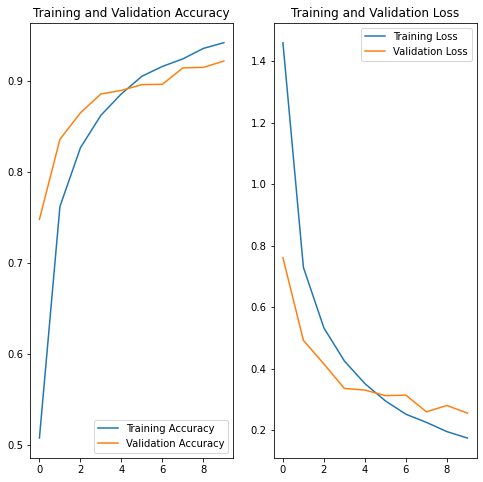

In [20]:
acc = history_wav_2.history['accuracy']
val_acc = history_wav_2.history['val_accuracy']

loss=history_wav_2.history['loss']
val_loss=history_wav_2.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Evaluation

In [21]:
model_spec_skip.load_weights(checkpoint_dir_2)
results = model_spec_skip.evaluate(test_dataset)
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

633/633 [==============================] - 6s 10ms/step - loss: 0.2556 - accuracy: 0.9220
loss value: 0.256
accuracy value: 92.1968%


## 회고 및 루브릭 평가

### 루브릭 평가 항목
1. 음성데이터를 2차원 Spectrogram 으로 변환하여 데이터셋을 구성하였다.(스펙트로그램 시각화 및 train/test 데이터셋 구성이 정상진행되었다.)

2. 1,2차원 데이터를 처리하는 음성인식 모델이 정상 작동한다.(스펙트로그램을 입력받은 모델이 학습과정에서 안정적으로 수렴하며, evaluation/test 단계를 무리없이 진행가능하다.)
3. 테스트셋 수행결과 음성인식 모델의 Accuracy가 일정 수준에 도달하였다.(evaluation 결과 75% 이상의 정확도를 달성하는 모델이 하나 이상 존재한다.)

### 평가 항목에 대한 수행
1. '1. Data processing'에서 먼저 음성 데이터를 훈련 데이터와 테스트 데이터로 나누었고, 그 후 훈련 데이터, 테스트 데이터 모두 spectrogram으로 변환을 하였다. 그 다음 '3. Dataset'에서 tensorflow를 이용하여 데이터셋을 구성하였다.
2. 데이터셋을 이용하여 2가지 모델에 대해서 '4. Modeling', '5. Training & visualization', '6. Evaluation'까지 모델을 학습하고 안정적으로 수렴하였고, 테스트(평가)까지 하였다.
3. 2가지 모델 모두 92% 이상의 정확도를 보인다.

### 회고

노션에 공지된 꼭 포함이 되어야 할 점
- 이번 프로젝트에서 **어려웠던 점,**
- 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
- 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.
- 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
- **자기 다짐**

---
- **어려웠던 점**    
우선, 프로젝트 하면서 jupyter notebook 커널이 10번 정도 죽은 것 같다.ㅠㅠ 그러면서 음성 데이터가 많이 무겁다는 것을 느꼈다. 예전에 프로젝트 하면서 batch 단위로만 로딩해서 쓰는 코드가 있었는데 그렇게 하면 해결이 될 것 같기도 하다. 여기서는 최대한 다른 프로그램 사용 없이 jupyter notebook만 이용하고(lms도 껐다.) batch size도 점점 줄이면서 해결을 했다. 그리고 어려운 점이 예제 코드에서 wav를 spectrogram으로 변환하는 것이 하나의 샘플에 대해서 였는데 이걸 전체 데이터에 대해서 적용하려고 해서 처음에 numpy.ndarry로 처리하려고 했다가 단순히 리스트로 하는 것이 빠르다는 것을 찾고 리스트로 해결을 하였다. 
---
- **알아낸 점**    
데이터 전처리 하다가 numpy.ndarry에 대해서 초기화하는 법이랑 초기화할 때 특정 차원 이상(default 32)을 만들 수 없다는 것을 알게 되었다. 그리고 음성 데이터를 처리하는 데 분류 문제라서 쉬울 수 있지만 작은 모델로도 상대이 좋은 성능을 낼 수 있는 것을 알 수 있었다. 

- **모호한 점**    
이건 어떤 의도인지 모르겠으나 예제에서 테스트 데이터를 validation에서도 쓰고 test에서도 쓰고 있어서 프로젝트에서도 그렇게 했는데 제대로 하려면 이것도 나눠야 하지 않나 생각이 든다. 그리고 2번째 모델이 약간 성능이 1번째에 비해서 낮은데 깊이가 낮으면 아마도 resnet에 skip 아이디어의 효과가 별로 없는 것 같다.(당연한 얘기인가?) 처음부터 성능이 너무 좋아서 다른 모델을 만들지 못했는데 다른 모델에서는 성능이 어떨지 궁금하다. 
---
- **시도한 것들**    
어려웠던 점에서 언급한 커널 죽는 문제를 해결하기 위해서 최대한 메모리를 아끼는 방법을 사용했고, wav를 spectrogram으로 변환하는 것에서 numpy.ndarry를 직접 다룰려고 했으나 실패하고 리스트로 하였다. 그리고 빠른 훈련을 위해서 모델을 축소시켰다.
---
- **우브릭 평가 관련 지표**   
제 예상에는 모두 달성되었다고 생각한다. 그 이유는 위에 있는 **평가 항목에 대한 수행**에 나와있다.  
- **자기 다짐** 및 **나의 생각들**      
예상치 못한 커널 죽는 문제로 시간이 좀 많이 소요된 것 같다. 좀 더 빠르게 하고 싶었지만 사소한 것에서 실수를 많이 한 것 같다. 지금 갑자기 기억이 났는데 2가지 모델에 대해서 코딩을 하다가 보니 변수명이 꼬여서 에러가 많이 났다. 그래서 약간 완벽하게 하고 싶어서(전에 노드도 마찬가지이다.) 모든 cell이 정확히 한 번만 실행이 되고 순서는 무조건 1번부터 순서대로 되어 있다. 즉, 중간에 코드를 삽입하거나 삭제하지 않은 무결한 코드인 것을 보여주고 있다.(사실 이게 가장 시간을 많이 소비한다.) 어쨌든 변수명으로 고생을 조금 겪고 나서 나머지는 빠르게 할 수 있었다. 소리 데이터에 대해서는 모델을 만들어 본 것이 처음이었다. 적어도 이 프로젝트에 도메인에서는 CNN을 이용하면 쉽게 좋은 성능을 낼 수 있다는 것을 알 수 있어서 좋았다. 하지만 wav와 spectrogram에 차이를 볼 수 없어서 아쉬웠다. 아마 spectrogram은 2차원이기 때문에 2차원 필터를 사용하는 CNN인 conv2d를 사용하면 달라지지 않았을까라는 추측만 해본다. 결과적인 얘기이지만 예제 때에 모델이 훈련하는데 너무 오래 걸려서 처음에 시험삼아 빠른 수행시간을 위해서 모델을 축소해봤는데 결과가 너무 좋아서 빠르게 마칠 수 있었던 것 같다. 그래서 하이퍼파라미터를 따로 조절하거나 모델을 수정할 일이 없었다. 음 그리고 예전에 소리 데이터에 대해서 약간 공부했던 것이 조금 도움이 된 것 같다. 이렇게 보니까 아무것도 안 한줄 알았는데 이것 저것 조금씩 공부를 해놓은 것 같다. 이 참에 FFT를 다시 정리하는 것도 좋을 것 같다.